1. Setup and Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import roc_curve, auc

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


2. Define the paths

In [3]:
# Define data paths
base_path = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data'
train_path = os.path.join(base_path, 'train_data')
val_path = os.path.join(base_path, 'val_data')
test_path = os.path.join(base_path, 'test_data')

In [4]:
output_dir = '/kaggle/working'
classification_dir = os.path.join(output_dir, 'classification_results')
triplet_dir = os.path.join(output_dir, 'triplet_results')

# Create directories for saving results
os.makedirs(classification_dir, exist_ok=True)
os.makedirs(triplet_dir, exist_ok=True)

3. Dataset class implementation

In [5]:
class FaceDataset(Dataset):
    """
    Dataset for loading face images with their class labels
    """
    def __init__(self, root, transform=None, load_all=False):
        self.root = root
        self.transform = transform
        self.unique_label_ids = os.listdir(self.root)
        print(f"Unique labels: {len(self.unique_label_ids)}")
        
        self.image_paths = []
        self.label_nums = []
        self.label_ids = []
        self.num_classes = len(self.unique_label_ids) 
        self.unique_label_nums = list(range(self.num_classes))
        
        # Iterate over each folder (each person)
        for label_num, label_id in enumerate(self.unique_label_ids):
            folder_path = os.path.join(self.root, label_id)
            
            # Get image paths
            images_list = os.listdir(folder_path)
            images_list_abs = [os.path.join(folder_path, image_path) for image_path in images_list]
            self.image_paths += images_list_abs
            
            # Create labels
            num_images = len(images_list)
            image_label_ids = [label_id] * num_images
            self.label_ids += image_label_ids
            
            # Create numeric labels
            image_label_nums = [label_num] * num_images
            self.label_nums += image_label_nums
            
        assert len(self.image_paths) == len(self.label_nums)
        
        self.data_len = len(self.label_nums)
        print(f"Total samples: {self.data_len}")
        
        # Dictionary for caching images
        self.images = {}
        if load_all:
            print("Loading all images...")
            for i in tqdm(range(self.data_len)):
                self.images[i] = self.__load_image(i)
                
    def __load_image(self, index):
        """Load a single image"""
        image_path = self.image_paths[index]
        x = Image.open(image_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        """Get an image and its label"""
        try:
            x = self.images[index]
        except KeyError:
            x = self.__load_image(index)
        return x, self.label_nums[index]
    
    def reduce_samples(self, ids):
        """Reduce dataset to contain only specified identity labels"""
        current_len = self.data_len
        new_image_paths = []
        new_label_nums = []
        new_label_ids = []
        
        for i in range(current_len):
            label_id = self.label_ids[i]
            image_path = self.image_paths[i]
            
            if label_id in ids:
                new_label_ids.append(label_id)
                new_image_paths.append(image_path)
                new_label_nums.append(ids.index(label_id)) 
        
        # Update labels
        self.label_ids = new_label_ids
        self.label_nums = new_label_nums
        self.unique_label_ids = ids
        self.num_classes = len(self.unique_label_ids)
        self.unique_label_nums = list(range(self.num_classes))
        
        # Update image paths and clear cache
        self.image_paths = new_image_paths
        self.images = {}
        
        self.data_len = len(new_label_ids)
        
        print(f"Before: {current_len}")
        print(f"After: {self.data_len}")
        print(f"Label nums: {len(self.label_nums)}")
        print(f"New Unique labels: {self.num_classes}")

4. Define parameters ad Image Transformations

In [24]:
# Define parameters
params = {
    'epochs': 25,
    'batch_size': 128,
    'num_labels': 500,  # Number of classes to use
    'embedding_dim': 128,  # Embedding dimension
    'triplet_margin': 0.3,  # Margin for triplet loss
}

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Input channels
IN_CHANNELS = 3

5. Load and prepare datasets

In [25]:
# Load training dataset
print("Loading Training Data")
train_dataset = FaceDataset(train_path, transform=transform)
labels = train_dataset.unique_label_ids[:params['num_labels']]
train_dataset.reduce_samples(labels)
print()

# Load validation dataset
print("Loading Validation Data")
val_dataset = FaceDataset(val_path, transform=transform)
val_dataset.reduce_samples(labels)

print("Loading Test Data")
test_dataset = FaceDataset(test_path, transform=transform)
test_dataset.reduce_samples(labels)

# Set number of classes
NUM_CLASSES = train_dataset.num_classes
print(f"Number of classes: {NUM_CLASSES}")

Loading Training Data
Unique labels: 4000
Total samples: 380638
Before: 380638
After: 47348
Label nums: 47348
New Unique labels: 500

Loading Validation Data
Unique labels: 4000
Total samples: 8000
Before: 8000
After: 1000
Label nums: 1000
New Unique labels: 500
Loading Test Data
Unique labels: 4000
Total samples: 8000
Before: 8000
After: 1000
Label nums: 1000
New Unique labels: 500
Number of classes: 500


6. Define CNN for Classification

In [10]:
class FaceClassificationModel(nn.Module):
    """
    CNN model for face classification with extractable embeddings
    """
    def __init__(self, in_channels, num_classes, embedding_dim=128):
        super(FaceClassificationModel, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate the size of flattened features
        # Input: 64x64 -> After 3 MaxPool: 8x8
        flat_features_size = 256 * 8 * 8
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_features_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
        # Classification layer
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x, return_embedding=False):
        x = self.features(x)
        embedding = self.embedding(x)
        
        # Normalize embedding for similarity calculations
        normalized_embedding = F.normalize(embedding, p=2, dim=1)
        
        if return_embedding:
            return normalized_embedding
        
        # Classification output
        logits = self.classifier(embedding)
        return logits, normalized_embedding

7. Define training and validation functions for classification

In [28]:
from sklearn.model_selection import ParameterSampler
import random

param_grid = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001],
    'momentum': [0.8, 0.85, 0.9, 0.95],
    'weight_decay': [1e-3, 1e-4, 5e-4, 1e-5],
    'embedding_dim': [32, 64, 128, 256, 512],
    'step_size': [2, 3, 5, 7],
    'gamma': [0.05, 0.1, 0.2, 0.5],
    'batch_size': [32, 64, 128, 256],  
}

n_iter_search = 16 
best_val_acc = 0
best_params = None

for params_trial in ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42):
    print(f"Testing params: {params_trial}")
    # Use the batch size from params_trial
    small_train_loader = DataLoader(
        torch.utils.data.Subset(train_dataset, list(range(0, min(1000, len(train_dataset))))),
        batch_size=params_trial['batch_size'], shuffle=True, num_workers=2
    )
    small_val_loader = DataLoader(
        torch.utils.data.Subset(val_dataset, list(range(0, min(200, len(val_dataset))))),
        batch_size=params_trial['batch_size'], shuffle=False, num_workers=2
    )
    model = FaceClassificationModel(
        in_channels=IN_CHANNELS,
        num_classes=NUM_CLASSES,
        embedding_dim=params_trial['embedding_dim']
    ).to(device)
    optimizer = optim.SGD(
        model.parameters(),
        lr=params_trial['lr'],
        momentum=params_trial['momentum'],
        weight_decay=params_trial['weight_decay']
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params_trial['step_size'], gamma=params_trial['gamma'])
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10):
        model.train()
        for inputs, labels in small_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, _ = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
    
    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in small_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits, _ = model(inputs)
            _, preds = torch.max(logits, 1)
            val_correct += torch.sum(preds == labels).item()
    val_acc = val_correct / len(small_val_loader.dataset)
    print(f"Validation accuracy: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params_trial

print(f"Best hyperparameters: {best_params}, Best validation accuracy: {best_val_acc:.4f}")

Testing params: {'weight_decay': 0.0005, 'step_size': 3, 'momentum': 0.9, 'lr': 0.001, 'gamma': 0.1, 'embedding_dim': 256, 'batch_size': 256}
Validation accuracy: 0.0450
Testing params: {'weight_decay': 1e-05, 'step_size': 2, 'momentum': 0.95, 'lr': 0.05, 'gamma': 0.1, 'embedding_dim': 128, 'batch_size': 128}
Validation accuracy: 0.0700
Testing params: {'weight_decay': 0.001, 'step_size': 7, 'momentum': 0.85, 'lr': 0.005, 'gamma': 0.2, 'embedding_dim': 32, 'batch_size': 32}
Validation accuracy: 0.0700
Testing params: {'weight_decay': 0.0005, 'step_size': 7, 'momentum': 0.8, 'lr': 0.001, 'gamma': 0.05, 'embedding_dim': 512, 'batch_size': 32}
Validation accuracy: 0.0750
Testing params: {'weight_decay': 1e-05, 'step_size': 3, 'momentum': 0.8, 'lr': 0.01, 'gamma': 0.5, 'embedding_dim': 64, 'batch_size': 256}
Validation accuracy: 0.0600
Testing params: {'weight_decay': 0.001, 'step_size': 7, 'momentum': 0.95, 'lr': 0.05, 'gamma': 0.1, 'embedding_dim': 512, 'batch_size': 64}
Validation accur

In [31]:
# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=2
)

In [32]:
def train_classification_model(model, train_loader, val_loader, epochs):
    """
    Train the classification model
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'], weight_decay=best_params['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_params['step_size'], gamma=best_params['gamma'])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epoch': []
    }
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits, _ = model(inputs)
            loss = criterion(logits, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            train_correct += torch.sum(preds == labels).item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{torch.sum(preds == labels).item() / inputs.size(0):.4f}"
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                logits, _ = model(inputs)
                loss = criterion(logits, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                val_correct += torch.sum(preds == labels).item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{torch.sum(preds == labels).item() / inputs.size(0):.4f}"
                })
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct / len(train_loader.dataset)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / len(val_loader.dataset)
        epoch_time = time.time() - start_time
        
        # Update scheduler
        scheduler.step()
        
        # Save metrics
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['time_per_epoch'].append(epoch_time)
        
        # Print summary
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, "
              f"Time: {epoch_time:.2f}s")
    return history

8. Train classification model

In [33]:
# Initialize and train classification model
classification_model = FaceClassificationModel(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    embedding_dim=best_params['embedding_dim']
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Classification model has {count_parameters(classification_model):,} trainable parameters")

# Train the model
classification_history = train_classification_model(
    classification_model, 
    train_loader, 
    val_loader, 
    params['epochs']
)

# Save the trained model
#torch.save(classification_model.state_dict(), 'classification_results/classification_model.pth')
torch.save(classification_model.state_dict(), os.path.join(classification_dir, 'classification_model.pth'))

Classification model has 10,057,524 trainable parameters


Epoch 1/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/25 - Train Loss: 5.1426, Train Acc: 0.0692, Val Loss: 4.5427, Val Acc: 0.0940, Time: 123.29s


Epoch 2/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/25 - Train Loss: 3.6786, Train Acc: 0.2202, Val Loss: 4.1048, Val Acc: 0.1620, Time: 46.04s


Epoch 3/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/25 - Train Loss: 2.9406, Train Acc: 0.3446, Val Loss: 3.2688, Val Acc: 0.2720, Time: 45.98s


Epoch 4/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/25 - Train Loss: 2.5584, Train Acc: 0.4160, Val Loss: 3.3941, Val Acc: 0.2670, Time: 45.96s


Epoch 5/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/25 - Train Loss: 2.3016, Train Acc: 0.4665, Val Loss: 2.9685, Val Acc: 0.3520, Time: 46.04s


Epoch 6/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/25 - Train Loss: 2.1355, Train Acc: 0.5003, Val Loss: 2.9552, Val Acc: 0.3400, Time: 45.85s


Epoch 7/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/25 - Train Loss: 2.0303, Train Acc: 0.5196, Val Loss: 3.1287, Val Acc: 0.3290, Time: 46.11s


Epoch 8/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/25 - Train Loss: 0.8944, Train Acc: 0.8018, Val Loss: 1.6699, Val Acc: 0.6160, Time: 46.04s


Epoch 9/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/25 - Train Loss: 0.4218, Train Acc: 0.9221, Val Loss: 1.6418, Val Acc: 0.6200, Time: 45.96s


Epoch 10/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/25 - Train Loss: 0.1952, Train Acc: 0.9808, Val Loss: 1.6701, Val Acc: 0.6130, Time: 45.92s


Epoch 11/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/25 - Train Loss: 0.0938, Train Acc: 0.9985, Val Loss: 1.6727, Val Acc: 0.6270, Time: 46.28s


Epoch 12/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/25 - Train Loss: 0.0642, Train Acc: 1.0000, Val Loss: 1.6617, Val Acc: 0.6210, Time: 45.87s


Epoch 13/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/25 - Train Loss: 0.0556, Train Acc: 1.0000, Val Loss: 1.6685, Val Acc: 0.6290, Time: 46.02s


Epoch 14/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/25 - Train Loss: 0.0518, Train Acc: 1.0000, Val Loss: 1.7007, Val Acc: 0.6190, Time: 46.22s


Epoch 15/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/25 - Train Loss: 0.0413, Train Acc: 1.0000, Val Loss: 1.6884, Val Acc: 0.6260, Time: 45.98s


Epoch 16/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/25 - Train Loss: 0.0403, Train Acc: 1.0000, Val Loss: 1.6980, Val Acc: 0.6200, Time: 45.85s


Epoch 17/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/25 - Train Loss: 0.0402, Train Acc: 1.0000, Val Loss: 1.7058, Val Acc: 0.6230, Time: 45.96s


Epoch 18/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/25 - Train Loss: 0.0403, Train Acc: 1.0000, Val Loss: 1.7059, Val Acc: 0.6200, Time: 45.80s


Epoch 19/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/25 - Train Loss: 0.0403, Train Acc: 1.0000, Val Loss: 1.7057, Val Acc: 0.6270, Time: 46.26s


Epoch 20/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/25 - Train Loss: 0.0401, Train Acc: 1.0000, Val Loss: 1.7079, Val Acc: 0.6240, Time: 45.92s


Epoch 21/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/25 - Train Loss: 0.0401, Train Acc: 1.0000, Val Loss: 1.7194, Val Acc: 0.6290, Time: 46.58s


Epoch 22/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/25 - Train Loss: 0.0395, Train Acc: 1.0000, Val Loss: 1.7145, Val Acc: 0.6180, Time: 45.88s


Epoch 23/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/25 - Train Loss: 0.0393, Train Acc: 1.0000, Val Loss: 1.7179, Val Acc: 0.6220, Time: 46.06s


Epoch 24/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/25 - Train Loss: 0.0392, Train Acc: 1.0000, Val Loss: 1.7198, Val Acc: 0.6230, Time: 45.84s


Epoch 25/25 [Train]:   0%|          | 0/740 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/25 - Train Loss: 0.0395, Train Acc: 1.0000, Val Loss: 1.7212, Val Acc: 0.6240, Time: 46.02s


9. Plot classfication results

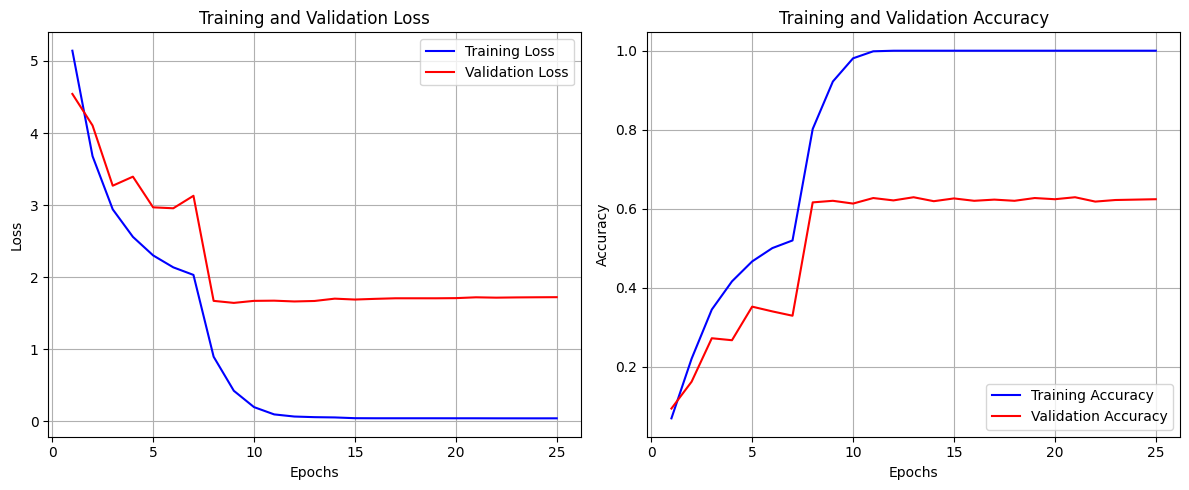

In [34]:
def plot_classification_results(history):
    """
    Plot training and validation metrics
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_classification_results(classification_history)

10. Implement Triplet dataset

In [35]:
class TripletFaceDataset(Dataset):
    """
    Dataset that returns triplets (anchor, positive, negative) for triplet loss training
    """
    def __init__(self, base_dataset, num_triplets=10000):
        self.base_dataset = base_dataset
        self.num_triplets = num_triplets
        
        # Group images by label
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(base_dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
        
        # Filter out labels with only one image
        self.valid_labels = [label for label in self.label_to_indices 
                             if len(self.label_to_indices[label]) > 1]
        
        # Generate triplets
        self.triplets = self._generate_triplets()
        
    def _generate_triplets(self):
        """Generate random triplets of (anchor, positive, negative)"""
        triplets = []
        for _ in range(self.num_triplets):
            # Select anchor label
            anchor_label = np.random.choice(self.valid_labels)
            
            # Select different label for negative
            negative_label = np.random.choice([l for l in self.valid_labels if l != anchor_label])
            
            # Select two different images for anchor and positive
            anchor_idx, pos_idx = np.random.choice(
                self.label_to_indices[anchor_label], 2, replace=False)
            
            # Select an image for negative
            neg_idx = np.random.choice(self.label_to_indices[negative_label])
            
            triplets.append((anchor_idx, pos_idx, neg_idx))
            
        return triplets
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, index):
        """Get a triplet of images"""
        a_idx, p_idx, n_idx = self.triplets[index]
        
        anchor_img, _ = self.base_dataset[a_idx]
        positive_img, _ = self.base_dataset[p_idx]
        negative_img, _ = self.base_dataset[n_idx]
        
        return anchor_img, positive_img, negative_img

11. Define Triplet Loss Model

In [36]:
class TripletLoss(nn.Module):
    """
    Triplet loss with margin
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        """
        Calculate triplet loss
        """
        # Calculate distances
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        
        # Calculate loss with margin
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        
        # Return mean loss
        return loss.mean()

class FaceTripletModel(nn.Module):
    """
    Model for triplet learning
    """
    def __init__(self, in_channels, embedding_dim=128):
        super(FaceTripletModel, self).__init__()
        
        # Feature extraction layers (same as classification model)
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate the size of flattened features
        flat_features_size = 256 * 8 * 8
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_features_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        embedding = self.embedding(x)
        
        # Normalize embedding
        normalized_embedding = F.normalize(embedding, p=2, dim=1)
        return normalized_embedding

12. Train Triplet Model

In [39]:
from sklearn.model_selection import ParameterSampler

triplet_param_grid = {
    'lr': [0.001, 0.0005, 0.0001, 5e-5],
    'weight_decay': [1e-3, 1e-4, 1e-5],
    'margin': [0.2, 0.3, 0.5, 1.0],
    'num_triplets': [5000, 10000, 15000]
}

n_iter_search = 8 
best_val_loss = float('inf')
best_triplet_params = None

for params_trial in ParameterSampler(triplet_param_grid, n_iter=n_iter_search, random_state=42):
    print(f"Testing triplet params: {params_trial}")
    triplet_dataset = TripletFaceDataset(train_dataset, num_triplets=params_trial['num_triplets'])
    triplet_loader = DataLoader(triplet_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=2)
    
    model = FaceTripletModel(
        in_channels=IN_CHANNELS,
        embedding_dim=best_params['embedding_dim']
    ).to(device)
    criterion = TripletLoss(margin=params_trial['margin'])
    optimizer = optim.Adam(model.parameters(), lr=params_trial['lr'], weight_decay=params_trial['weight_decay'])

    for epoch in range(3):
        model.train()
        epoch_loss = 0.0
        for anchor, positive, negative in triplet_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            optimizer.zero_grad()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            epoch_loss += loss.item() * anchor.size(0)
            loss.backward()
            optimizer.step()
    avg_loss = epoch_loss / len(triplet_loader.dataset)
    print(f"Avg training loss: {avg_loss:.4f}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        best_triplet_params = params_trial

print(f"Best triplet hyperparameters: {best_triplet_params}, Best avg training loss: {best_val_loss:.4f}")

Testing triplet params: {'weight_decay': 0.001, 'num_triplets': 5000, 'margin': 0.3, 'lr': 5e-05}
Avg training loss: 0.0351
Testing triplet params: {'weight_decay': 0.0001, 'num_triplets': 5000, 'margin': 0.5, 'lr': 0.001}
Avg training loss: 0.2824
Testing triplet params: {'weight_decay': 0.0001, 'num_triplets': 5000, 'margin': 0.3, 'lr': 0.0001}
Avg training loss: 0.0405
Testing triplet params: {'weight_decay': 0.0001, 'num_triplets': 15000, 'margin': 0.5, 'lr': 0.0001}
Avg training loss: 0.1739
Testing triplet params: {'weight_decay': 1e-05, 'num_triplets': 5000, 'margin': 0.5, 'lr': 0.0005}
Avg training loss: 0.2552
Testing triplet params: {'weight_decay': 0.001, 'num_triplets': 10000, 'margin': 0.3, 'lr': 0.001}
Avg training loss: 0.2137
Testing triplet params: {'weight_decay': 0.001, 'num_triplets': 15000, 'margin': 0.5, 'lr': 5e-05}
Avg training loss: 0.1566
Testing triplet params: {'weight_decay': 1e-05, 'num_triplets': 5000, 'margin': 1.0, 'lr': 0.0005}
Avg training loss: 0.669

In [42]:
def train_triplet_model(model, epochs, margin=0.3, num_triplets=10000, lr=0.0001, weight_decay=1e-5, batch_size=64):
    """
    Train the triplet model using specified hyperparameters
    """
    # Create triplet dataset and dataloader
    triplet_dataset = TripletFaceDataset(train_dataset, num_triplets=num_triplets)
    triplet_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize loss and optimizer
    criterion = TripletLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training history
    history = {
        'loss': [],
        'time_per_epoch': []
    }
    
    print(f"Training triplet model with {len(triplet_dataset)} triplets")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        epoch_loss = 0.0
        
        progress_bar = tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs} [Triplet]")
        for anchor, positive, negative in progress_bar:
            # Move data to device
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            # Calculate loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            epoch_loss += loss.item() * anchor.size(0)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(triplet_loader.dataset)
        epoch_time = time.time() - start_time
        
        # Save metrics
        history['loss'].append(avg_loss)
        history['time_per_epoch'].append(epoch_time)
        
        # Print summary
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {avg_loss:.4f}, "
              f"Time: {epoch_time:.2f}s")
    return history

triplet_model = FaceTripletModel(
    in_channels=IN_CHANNELS,
    embedding_dim=best_params['embedding_dim']
).to(device)

print(f"Triplet model has {count_parameters(triplet_model):,} trainable parameters")

triplet_history = train_triplet_model(
    triplet_model, 
    epochs=params['epochs'],
    margin=best_triplet_params['margin'],
    num_triplets=best_triplet_params['num_triplets'],
    lr=best_triplet_params['lr'],
    weight_decay=best_triplet_params['weight_decay'],
    batch_size=best_params['batch_size']
)

torch.save(triplet_model.state_dict(), os.path.join(triplet_dir, 'triplet_model.pth'))

Triplet model has 9,801,024 trainable parameters
Training triplet model with 5000 triplets


Epoch 1/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/25 - Loss: 0.2198, Time: 14.14s


Epoch 2/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/25 - Loss: 0.1003, Time: 14.24s


Epoch 3/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/25 - Loss: 0.0355, Time: 14.52s


Epoch 4/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/25 - Loss: 0.0109, Time: 14.49s


Epoch 5/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/25 - Loss: 0.0058, Time: 14.32s


Epoch 6/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/25 - Loss: 0.0045, Time: 14.20s


Epoch 7/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/25 - Loss: 0.0027, Time: 14.27s


Epoch 8/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/25 - Loss: 0.0022, Time: 14.28s


Epoch 9/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/25 - Loss: 0.0011, Time: 14.34s


Epoch 10/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/25 - Loss: 0.0021, Time: 14.32s


Epoch 11/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/25 - Loss: 0.0044, Time: 14.29s


Epoch 12/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/25 - Loss: 0.0036, Time: 14.26s


Epoch 13/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/25 - Loss: 0.0023, Time: 14.32s


Epoch 14/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/25 - Loss: 0.0026, Time: 14.25s


Epoch 15/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/25 - Loss: 0.0016, Time: 14.25s


Epoch 16/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/25 - Loss: 0.0018, Time: 14.32s


Epoch 17/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/25 - Loss: 0.0010, Time: 14.23s


Epoch 18/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/25 - Loss: 0.0020, Time: 14.34s


Epoch 19/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/25 - Loss: 0.0027, Time: 14.34s


Epoch 20/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/25 - Loss: 0.0029, Time: 14.31s


Epoch 21/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/25 - Loss: 0.0030, Time: 14.27s


Epoch 22/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/25 - Loss: 0.0017, Time: 14.30s


Epoch 23/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/25 - Loss: 0.0009, Time: 14.16s


Epoch 24/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/25 - Loss: 0.0029, Time: 14.38s


Epoch 25/25 [Triplet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/25 - Loss: 0.0028, Time: 14.40s


13. Plot Triplet Training Results

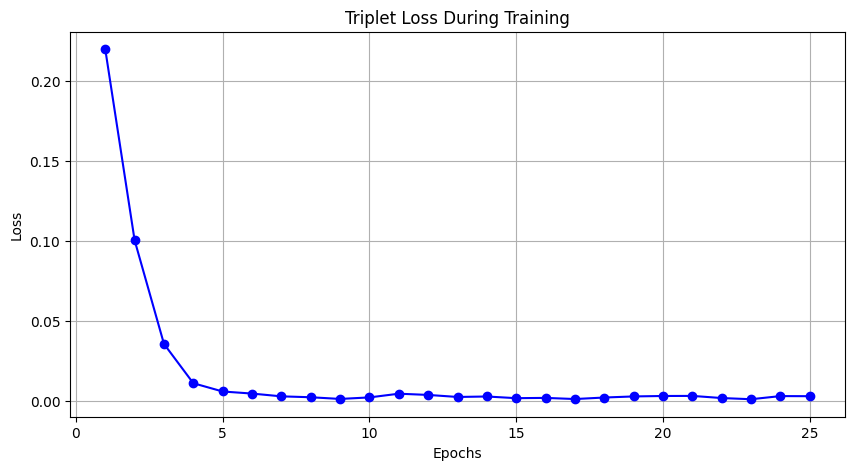

In [43]:
def plot_triplet_results(history):
    """
    Plot triplet training loss
    """
    epochs = range(1, len(history['loss']) + 1)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['loss'], 'b-', marker='o')
    plt.title('Triplet Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Plot the results
plot_triplet_results(triplet_history)

14. Load Test Dataset and Verification Dataset

In [44]:
class VerificationDataset(Dataset):
    """
    Dataset for loading face verification pairs
    """
    def __init__(self, pairs_file, transform=None, base_dir='/kaggle/input/11-785-fall-20-homework-2-part-2'):
        self.pairs_file = pairs_file
        self.transform = transform
        self.base_dir = base_dir  # Base directory to prepend to relative paths
        self.pairs = []
        self.labels = []
        
        try:
            # Load verification pairs
            with open(pairs_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 3:
                        img1_path, img2_path, label = parts
                        # Create full paths by joining with the base directory
                        img1_full_path = os.path.join(self.base_dir, img1_path)
                        img2_full_path = os.path.join(self.base_dir, img2_path)
                        self.pairs.append((img1_full_path, img2_full_path))
                        self.labels.append(int(label))
            
            print(f"Loaded {len(self.pairs)} verification pairs from {pairs_file}")
        except FileNotFoundError:
            print(f"Warning: Verification file {pairs_file} not found.")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        img1_path, img2_path = self.pairs[index]
        label = self.labels[index]
        
        # Load images
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except FileNotFoundError as e:
            print(f"Error loading image: {e}")
            # Return a placeholder or raise the error
            raise
        
        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [45]:
verification_file = os.path.join('/kaggle/input/11-785-fall-20-homework-2-part-2', 'verification_pairs_val.txt')
verification_dataset = VerificationDataset(
    verification_file, 
    transform=transform,
    base_dir='/kaggle/input/11-785-fall-20-homework-2-part-2'
)
print(f"Verification dataset loaded with {len(verification_dataset)} pairs")

Loaded 8805 verification pairs from /kaggle/input/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt
Verification dataset loaded with 8805 pairs


15. Evaluate Models on Test Data

In [46]:
def evaluate_classifier_on_test(model, test_loader):
    """Evaluate classification model on test data"""
    model.eval()
    test_loss = 0.0
    test_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating classification model on test data")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            logits, _ = model(inputs)
            loss = criterion(logits, labels)
            
            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            test_correct += torch.sum(preds == labels).item()
            
            # Store for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot confusion matrix (optional)
    if len(np.unique(all_labels)) <= 20:  # Only if we have a manageable number of classes
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig(os.path.join(output_dir, 'test_confusion_matrix.png'))
        plt.show()
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': all_preds,
        'true_labels': all_labels
    }

def evaluate_verification(model, verification_dataset, name="model"):
    """
    Evaluate a model on verification pairs
    """
    model.eval()
    cosine_similarities = []
    euclidean_distances = []
    labels = []
    
    with torch.no_grad():
        for img1, img2, label in tqdm(verification_dataset, desc=f"Evaluating {name} on verification pairs"):
            img1 = img1.unsqueeze(0).to(device)
            img2 = img2.unsqueeze(0).to(device)
            
            # Get embeddings
            if isinstance(model, FaceClassificationModel):
                _, emb1 = model(img1)
                _, emb2 = model(img2)
            else:  # Triplet model
                emb1 = model(img1)
                emb2 = model(img2)
            
            # Calculate cosine similarity
            cos_sim = F.cosine_similarity(emb1, emb2).item()
            cosine_similarities.append(cos_sim)
            
            # Calculate Euclidean distance (negative so higher is better)
            euc_dist = -torch.pairwise_distance(emb1, emb2).item()
            euclidean_distances.append(euc_dist)
            
            labels.append(label)
    
    # Calculate ROC and AUC for cosine similarity
    fpr_cos, tpr_cos, thresholds_cos = roc_curve(labels, cosine_similarities)
    auc_cos = auc(fpr_cos, tpr_cos)
    
    # Calculate ROC and AUC for Euclidean distance
    fpr_euc, tpr_euc, thresholds_euc = roc_curve(labels, euclidean_distances)
    auc_euc = auc(fpr_euc, tpr_euc)
    
    # Find best threshold and accuracy for cosine similarity
    best_acc_cos = 0
    best_threshold_cos = 0
    
    for threshold in thresholds_cos:
        predictions = [1 if s >= threshold else 0 for s in cosine_similarities]
        accuracy = np.mean([1 if p == l else 0 for p, l in zip(predictions, labels)])
        if accuracy > best_acc_cos:
            best_acc_cos = accuracy
            best_threshold_cos = threshold
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_cos, tpr_cos, label=f'Cosine Similarity (AUC = {auc_cos:.4f})')
    plt.plot(fpr_euc, tpr_euc, label=f'Euclidean Distance (AUC = {auc_euc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name.capitalize()} Model - Verification ROC')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"{name.capitalize()} Model Results:")
    print(f"Cosine Similarity AUC: {auc_cos:.4f}")
    print(f"Euclidean Distance AUC: {auc_euc:.4f}")
    print(f"Best Accuracy: {best_acc_cos:.4f} (threshold: {best_threshold_cos:.4f})")
    
    return {
        'cosine_auc': auc_cos,
        'euclidean_auc': auc_euc,
        'best_accuracy': best_acc_cos,
        'best_threshold': best_threshold_cos
    }

16. Evaluate Models and Compare Results


1. Testing Classification Model on Test Data


Evaluating classification model on test data:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 1.6929, Test Accuracy: 0.6360

2. Testing Models on Verification Pairs

Evaluating Classification Model on Verification:


Evaluating classification on verification pairs:   0%|          | 0/8805 [00:00<?, ?it/s]

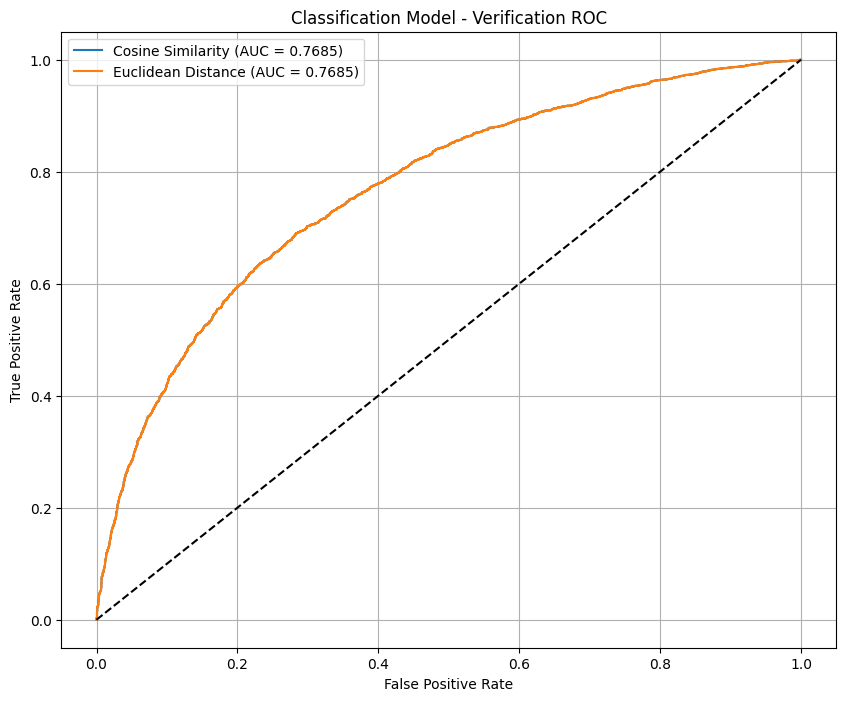

Classification Model Results:
Cosine Similarity AUC: 0.7685
Euclidean Distance AUC: 0.7685
Best Accuracy: 0.7035 (threshold: 0.1344)

Evaluating Triplet Model on Verification:


Evaluating triplet on verification pairs:   0%|          | 0/8805 [00:00<?, ?it/s]

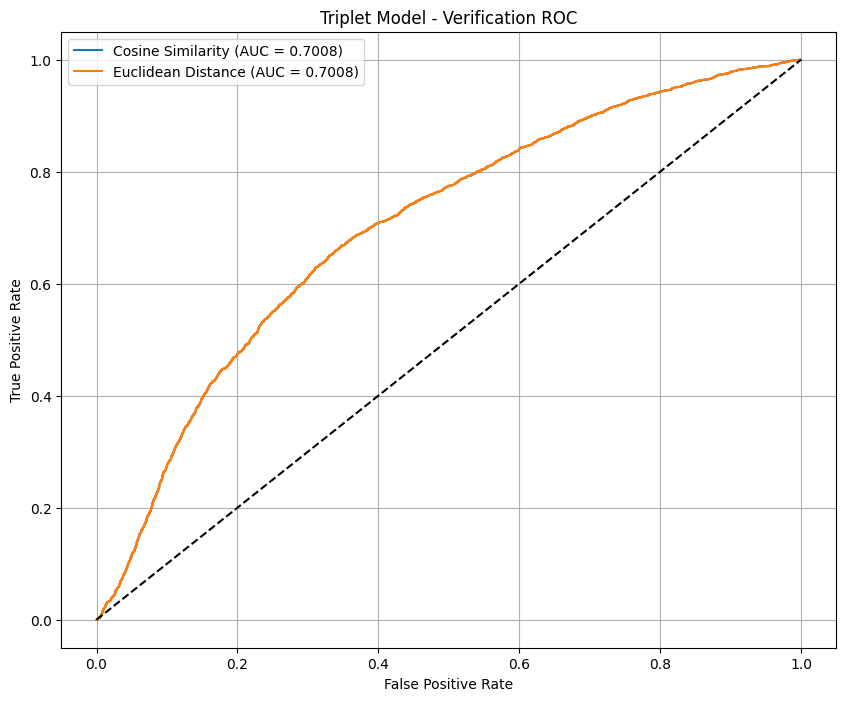

Triplet Model Results:
Cosine Similarity AUC: 0.7008
Euclidean Distance AUC: 0.7008
Best Accuracy: 0.6602 (threshold: 0.0938)

=== Verification Performance Comparison ===
Classification Model - Cosine AUC: 0.7685, Euclidean AUC: 0.7685, Best Accuracy: 0.7035
Triplet Model - Cosine AUC: 0.7008, Euclidean AUC: 0.7008, Best Accuracy: 0.6602

=== Final Conclusion ===
The Classification model performed better for verification using cosine similarity.
The Classification model performed better for verification using Euclidean distance.

=== Generalization Analysis ===
Train-Val Accuracy Gap: 0.3760
Val-Test Accuracy Gap: -0.0120
The classification model shows signs of overfitting between training and validation.


In [47]:
# 1. Evaluate Classification Model on Test Data
print("\n1. Testing Classification Model on Test Data")
classification_test_results = evaluate_classifier_on_test(classification_model, test_loader)

# 2. Evaluate both models on Verification Pairs
print("\n2. Testing Models on Verification Pairs")

# Evaluate classification model on verification dataset
print("\nEvaluating Classification Model on Verification:")
classification_verification_results = evaluate_verification(
    classification_model, 
    verification_dataset, 
    name="classification"
)

# Evaluate triplet model on verification dataset
print("\nEvaluating Triplet Model on Verification:")
triplet_verification_results = evaluate_verification(
    triplet_model, 
    verification_dataset, 
    name="triplet"
)

# 3. Compare verification performance (simple text comparison)
print("\n=== Verification Performance Comparison ===")
print(f"Classification Model - Cosine AUC: {classification_verification_results['cosine_auc']:.4f}, "
      f"Euclidean AUC: {classification_verification_results['euclidean_auc']:.4f}, "
      f"Best Accuracy: {classification_verification_results['best_accuracy']:.4f}")

print(f"Triplet Model - Cosine AUC: {triplet_verification_results['cosine_auc']:.4f}, "
      f"Euclidean AUC: {triplet_verification_results['euclidean_auc']:.4f}, "
      f"Best Accuracy: {triplet_verification_results['best_accuracy']:.4f}")

# 4. Determine best model
print("\n=== Final Conclusion ===")
if classification_verification_results['cosine_auc'] > triplet_verification_results['cosine_auc']:
    print("The Classification model performed better for verification using cosine similarity.")
else:
    print("The Triplet model performed better for verification using cosine similarity.")
    
if classification_verification_results['euclidean_auc'] > triplet_verification_results['euclidean_auc']:
    print("The Classification model performed better for verification using Euclidean distance.")
else:
    print("The Triplet model performed better for verification using Euclidean distance.")

# 5. Generalization assessment for classification model
train_val_gap = classification_history['train_acc'][-1] - classification_history['val_acc'][-1]
val_test_gap = classification_history['val_acc'][-1] - classification_test_results['accuracy']

print("\n=== Generalization Analysis ===")
print(f"Train-Val Accuracy Gap: {train_val_gap:.4f}")
print(f"Val-Test Accuracy Gap: {val_test_gap:.4f}")

if train_val_gap > 0.05:
    print("The classification model shows signs of overfitting between training and validation.")
if val_test_gap > 0.05:
    print("The classification model shows signs of overfitting between validation and test.")
if train_val_gap <= 0.05 and val_test_gap <= 0.05:
    print("The classification model generalizes well across datasets.")